In [4]:
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.util import img_as_bool, img_as_uint, img_as_ubyte, img_as_int
from skimage.transform import resize
from skimage.morphology import label
import random
from random import randint 
from keras import regularizers
from keras.models import Model, load_model
from keras.optimizers import Adam, SGD, RMSprop
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Activation, Dense, \
    UpSampling2D, BatchNormalization, add, Dropout, Flatten
from keras.layers.core import Lambda
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from keras import backend as K
from keras.losses import binary_crossentropy, sparse_categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img


# Root folders for test and training data
train_root = "./stage1_train"
test_root = "./stage1_test"

# Size we resize all images to
#image_size = (128,128)

img_height = 128
img_width = 128
img_channels = 1 # 1 for B&W, 3 for RGB

import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
#warnings.resetwarnings()

In [9]:
# Import images (either test or training)
# Decolorize, resize, store in array, and save filenames, etc.
def import_images(root):
    dirs = os.listdir(root)
    filenames=[os.path.join(root,file_id) + "/images/"+file_id+".png" for file_id in dirs]
    images=[imread(imagefile,as_grey=True) for imagefile in filenames]
    # Create array with resized images
    Array = np.reshape(np.array([ resize(image,(img_width,img_height)) for image in images] ),
                       (len(images),img_height,img_width,img_channels))    
    print(Array.mean())
    print(Array.std())

    # Normalize inputs - NOTE THIS CONVERTS TO FLOAT64
    Array = ((Array - Array.mean())/Array.std())

    print(Array.mean())
    print(Array.std())
    print(images[0].dtype)
    print(Array[0,0,0,0].dtype)
    return Array, images, filenames, dirs

train_X, train_images, train_filenames, train_dirs = import_images(train_root)

0.160902796657
0.249621650769
1.26292011674e-15
1.0
float64
float64


In [10]:
## Import Training Masks
# this takes longer than the training images because we have to
# combine a lot of mask files

# This function creates a single combined mask image 
# when given a list of masks
def collapse_masks(mask_list):
    for i, mask_file in enumerate(mask_list):        
        if i != 0:
            # combine mask with previous mask in list 
            mask = np.maximum(mask, imread(os.path.join(train_root,mask_file)))
        else:
            # read first mask in
            mask = imread(os.path.join(train_root,mask_file))
    
    return mask

# Import all the masks
train_mask_dirs = [ os.path.join(path, 'masks') for path in os.listdir(train_root) ]
train_mask_files = [ [os.path.join(dir,file) for file in os.listdir(os.path.join(train_root,dir)) ]  for dir in train_mask_dirs]
train_masks = [ collapse_masks(mask_files) for mask_files in train_mask_files ]
train_Y = np.reshape(np.array([ img_as_bool(resize(image,(img_width,img_height))) for image in train_masks] ),
    (len(train_masks),img_height,img_width,img_channels))

In [14]:
print(train_X.shape)
print(train_Y.shape)

(670, 128, 128, 1)
(670, 128, 128, 1)


0
(128, 128)


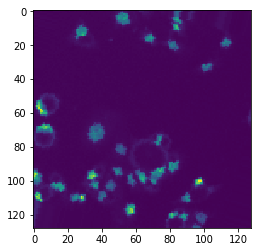

0
(128, 128)


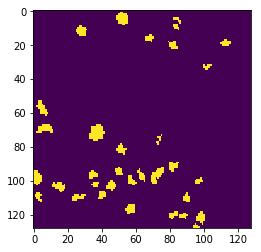

In [46]:
# Data Augmentation / Pre-processing

datagen = ImageDataGenerator(
        rotation_range=40,
       # width_shift_range=0.2,
       # height_shift_range=0.2,
        shear_range=0.2,
       # zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')



seed=1
#datagen.fit(train_X)
j=0
for train_X_gen in datagen.flow(train_X, batch_size=1,seed=seed):
    print(j)
    print(np.squeeze(train_X_gen,axis=(0,3)).shape)
    plt.imshow(np.squeeze(train_X_gen,axis=(0,3)))
    plt.show()
  #  plt.imshow(np.squeeze(train_X_gen,axis=(0,3)))
  #  plt.show()
    j+=1 
    if j >= 1:
        break

j=0
for train_X_gen in datagen.flow(train_Y, batch_size=1,seed=seed):
    print(j)
    print(np.squeeze(train_X_gen,axis=(0,3)).shape)
    plt.imshow(np.squeeze(train_X_gen,axis=(0,3)))
    plt.show()
  #  plt.imshow(np.squeeze(train_X_gen,axis=(0,3)))
  #  plt.show()
    j+=1 
    if j >= 1:
        break

# Configure batch size and retrieve one batch of images

#"""for X_batch, y_batch in datagen.flow(train_X, train_Y, batch_size=9):
#    # Show 9 images
#    for i in range(0, 9):
#        #plt.subplot(330 + 1 + i)
#        plt.imshow(X_batch[i])
#        plt.imshow(y_batch[i])
#    # show the plot
#    plt.show()
#    break"""

# fits the model on batches with real-time data augmentation:
#data_aug = model.fit_generator(datagen.flow(train_X, train_Y, batch_size=1),
#                    steps_per_epoch=len(train_X), epochs=epochs)

In [ ]:
Example of transforming images and masks together.

# we create two instances with the same arguments
data_gen_args = dict(featurewise_center=True,
                     featurewise_std_normalization=True,
                     rotation_range=90.,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.2)
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# Provide the same seed and keyword arguments to the fit and flow methods
seed = 1
image_datagen.fit(images, augment=True, seed=seed)
mask_datagen.fit(masks, augment=True, seed=seed)

image_generator = image_datagen.flow_from_directory(
    'data/images',
    class_mode=None,
    seed=seed)

mask_generator = mask_datagen.flow_from_directory(
    'data/masks',
    class_mode=None,
    seed=seed)

# combine generators into one which yields image and masks
train_generator = zip(image_generator, mask_generator)

model.fit_generator(
    train_generator,
    steps_per_epoch=2000,
    epochs=50)

In [ ]:
### For use when using two arrays

for train_X_gen in datagen.flow(train_X, batch_size=1,seed=1337):
    print(j)
    print(np.squeeze(train_X_gen,axis=(0,3)).shape)
    plt.imshow(np.squeeze(train_X_gen[0],axis=(0,3)))
    plt.show()
    plt.imshow(np.squeeze(train_X_gen[1],axis=(0,3)))
    plt.show()
    j+=1 
    if j >= 2:
        break